# Differentiation

In this tutorial, we will look at a number of ways to calculate the derivative of a function, and also look at how we might use these derivatives in an optimisation process using gradient descent.

## Differentiation by hand

Given a sufficiently simple function, it can be easy to compute its derivative by hand. For example in the code below, we compute the derivative of `x**3`:

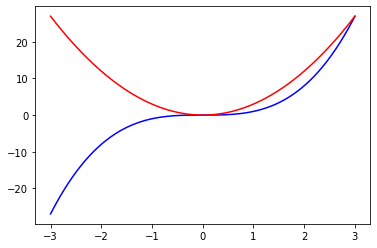

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-3, 3, num=1000)
x_cubed = x**3

# The derivative of x**3 is 3*x**2
x_deriv = 3 * (x ** 2)

plt.plot(x, x_cubed, "b")
plt.plot(x, x_deriv, "r")

If you have a more complex function, but the function is still known, it may also be possible to get the computer to compute the derivative for you using a symbolic differentiation package such as [sympy](https://www.sympy.org/en/index.html).

## Finite differences

Sometimes you may only have access to the output of a function, and not have a defined mathematical formula describing it. In this case differentiating as shown above is not possible. However it is still possible to estimate the derivative using [finite difference](https://en.wikipedia.org/wiki/Finite_difference) methods.

The most straightforward way to estimate the gradient of a function f(x) is to pick a small offset h, and then compute the forward difference f(x+h) - f(x) / h

We can do this manually using a for loop:

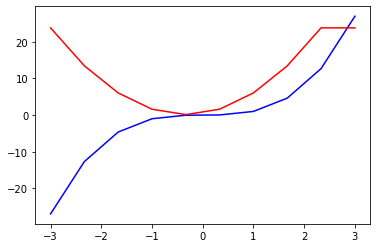

In [23]:
n_samples = 1000

x = np.linspace(-3, 3, num=n_samples)
x_cubed = x**3

h = (3 - (-3)) / n_samples # The step size

def finite_differences(values, stepsize):
    deriv = np.zeros_like(values)

    for i in range(len(x)-1):
        deriv[i] = (values[i+1] - values[i]) / stepsize

    # For the last element we have to use a backward difference:
    deriv[-1] = (values[-1] - values[-2]) / stepsize
    return deriv

x_deriv_est = finite_differences(x_cubed, h)

plt.plot(x, x_cubed, "b")
plt.plot(x, x_deriv_est, "r")

In this case this approximates the true gradient reasonably well:

False


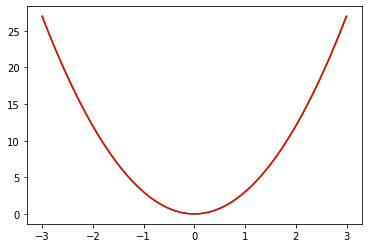

In [15]:
plt.plot(x, x_deriv, "g")
plt.plot(x, x_deriv_est, "r")

# But it isn't close enough for np.allclose():
print(np.allclose(x_deriv, x_deriv_est))

Numpy has a built in function `numpy.gradient()` that computes gradients. This also uses a finite differences method, but a more sophisticated second order implementation (see the [documentation](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html) for details).

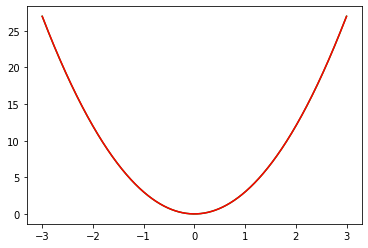

In [21]:
n_samples = 1000

x = np.linspace(-3, 3, num=n_samples)
x_cubed = x**3

h = (3 - (-3)) / n_samples # The step size

grad = np.gradient(x_cubed, h)

plt.plot(x, x_deriv, "g")
plt.plot(x, grad, "r")

It's important to remember that how well any finite differences methods will work depends heavily on the function and the step size h. If the function is too complex or the step size too large, the gradient may be very inaccurate.